In [16]:
from gurobipy import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

## Optimization Project
Jingxuan SUN (js3422) & Zimeng ZHU (zz629)

In [2]:
#initialize data
#airport A = 0, B = 1, C = 2

#time period of a week
days = 5

#cost of transfer empty flight
ce = [[0, 7, 3], [7, 0, 6], [3, 6, 0]]
#cost of hold cargo
ch = 10

# cargo arrival
a = [[[0, 100, 50], [25, 0, 25], [40, 400, 0]], 
     [[0, 200, 50], [25, 0, 25], [40, 200, 0]],
     [[0, 100, 50], [25, 0, 25], [40, 300, 0]],
     [[0, 400, 50], [25, 0, 25], [40, 200, 0]],
     [[0, 300, 50], [25, 0, 25], [40, 400, 0]]]

In [24]:
class myModel:
    def __init__(self, days, ce, ch, name):
        self.days = days
        self.ce = ce
        self.ch = ch
        self.x = [[[None for _ in range(3)] for _ in range(3)] for _ in range(days)]
        self.y = [[[None for _ in range(3)] for _ in range(3)] for _ in range(days)]
        self.z = [[None for _ in range(3)] for _ in range(days)]
        self.w = [[[None for _ in range(3)] for _ in range(3)] for _ in range(days)]
        self.name = name
         
        self.model = Model(name)
        for t in range(self.days):
            for s in range(3):
                self.z[t][s] = self.model.addVar(vtype=GRB.INTEGER, 
                                                 name='z_'+str(t)+'_'+str(s))
                for e in range(3):
                    if s == e:
                        continue
                    self.x[t][s][e] = self.model.addVar(vtype=GRB.INTEGER, 
                                                        name='x_'+str(t)+'_'+str(s)+'_'+str(e))
                    self.y[t][s][e] = self.model.addVar(vtype=GRB.INTEGER, 
                                                        name='y_'+str(t)+'_'+str(s)+'_'+str(e))
                    self.w[t][s][e] = self.model.addVar(vtype=GRB.INTEGER, 
                                                        name='w_'+str(t)+'_'+str(s)+'_'+str(e))
        self.model.update()

        self.objExpr = LinExpr()
        for t in range(self.days):
            for s in range(3):
                for e in range(3):
                    if s == e:
                        continue
                    self.objExpr += self.ce[s][e] * self.y[t][s][e] \
                                    + self.ch * self.w[t][s][e]
        self.model.setObjective(self.objExpr, GRB.MINIMIZE) 

        #aircraft in and out constraints for every day and every airport
        for t in range(self.days):
            prev = (t + 4) % self.days
            for s in range(3):
                out_flow = LinExpr()
                in_flow = LinExpr()
                out_flow += self.z[t][s]
                in_flow += self.z[prev][s]
                for e in range(3):
                    if s == e:
                        continue
                    out_flow += self.x[t][s][e] + self.y[t][s][e]
                    in_flow += self.x[prev][e][s] + self.y[prev][e][s]
                self.model.addConstr(lhs = out_flow, sense = GRB.EQUAL, rhs = in_flow, 
                                     name = "constr_aircraft_flow_" + str(t)+'_'+str(s))

        self.model.update()
        
    def add_fleet(self, fleet):
        for t in range(self.days):
            left = LinExpr()
            for s in range(3):
                left += self.z[t][s]
                for e in range(3):
                    if s == e:
                        continue
                    left += self.x[t][s][e] + self.y[t][s][e]
            self.model.addConstr(lhs = left, sense = GRB.EQUAL, rhs = fleet, 
                                 name = "constr_num_aircraft_" + str(t))
        self.model.update()
        
    def add_cargo(self, a):
        for t in range(self.days):
            prev = (t + 4) % self.days
            for s in range(3):
                for e in range(3):
                    if s == e:
                        continue
                    today = LinExpr()
                    last = LinExpr()
                    today += self.w[t][s][e]
                    last += -1 * self.x[prev][s][e] + a[prev][s][e] + self.w[prev][s][e]
                    self.model.addConstr(lhs=today, sense=GRB.EQUAL, rhs=last, 
                                         name='constr_cargo_'+str(t)+'_'+str(s)+'_'+str(e))
        self.model.update()

In [26]:
def optimize_model(name, fleet, a):
    print('========== new model ==========')
    print('model {}'.format(name))
    print('fleet={}'.format(fleet))
    print('arrivals:')
    pprint(a)
    print()
    
    model = myModel(days, ce, ch, name)
    model.add_fleet(fleet)
    model.add_cargo(a)
#     model.model.write('{}.lp'.format(name))
    model.model.optimize()
    
    print('\nOptimal Objective: {}'.format(model.model.ObjVal))
    print('\nOptimal Solution:')
    vars = model.model.getVars()
    for var in vars:
        if var.x != 0:
            print('{} = {}'.format(var.varName, var.x))
    
    # get vars value
    x_value = [[[None for _ in range(3)] for _ in range(3)] for _ in range(days)]
    for t in range (days):
        for i in range(3):
            for j in range(3):  
                if model.x[t][i][j] is not None:
                    curVar = model.x[t][i][j]
                    x_value[t][i][j] = curVar.x
    
    y_value = [[[None for _ in range(3)] for _ in range(3)] for _ in range(days)]
    for t in range (days):
        for i in range(3):
            for j in range(3):  
                if model.y[t][i][j] is not None:
                    curVar = model.y[t][i][j]
                    y_value[t][i][j] = curVar.x
    
    z_value = [[None for _ in range(3)] for _ in range(days)]
    for t in range (days):
        for i in range(3):
            if model.z[t][i] is not None:
                curVar = model.z[t][i]
                z_value[t][i] = curVar.x
    
    w_value = [[[None for _ in range(3)] for _ in range(3)] for _ in range(days)]
    for t in range (days):
        for i in range(3):
            for j in range(3):  
                if model.w[t][i][j] is not None:
                    curVar = model.w[t][i][j]
                    w_value[t][i][j] = curVar.x
    
    return [x_value, y_value, z_value, w_value]

In [211]:
# fleet < 1200 infeasible
ivs_fleet = [('f1200', 1200, a), ('f1300', 1300, a), 
             ('f1400', 1400, a), ('f1500', 1500, a)]

a1 = [[[0, 110, 100], [110, 0, 110], [100, 110, 0]], 
     [[0, 130, 120], [120, 0, 120], [120, 130, 0]],
     [[0, 90, 90], [90, 0, 90], [90, 90, 0]],
     [[0, 130, 120], [120, 0, 120], [120, 130, 0]],
     [[0, 140, 140], [140, 0, 140], [140, 140, 0]]]

# a2 infeasible
a2 = [[[0, 150, 10], [10, 0, 10], [10, 450, 0]], 
     [[0, 250, 10], [10, 0, 10], [10, 250, 0]],
     [[0, 150, 10], [10, 0, 10], [10, 350, 0]],
     [[0, 450, 10], [10, 0, 10], [10, 250, 0]],
     [[0, 350, 10], [10, 0, 10], [10, 450, 0]]]

a3 = [[[0, 120, 25], [25, 0, 25], [25, 420, 0]], 
     [[0, 220, 25], [25, 0, 25], [25, 220, 0]],
     [[0, 120, 25], [25, 0, 25], [25, 320, 0]],
     [[0, 420, 25], [25, 0, 25], [25, 220, 0]],
     [[0, 320, 25], [25, 0, 25], [25, 420, 0]]]

ivs_arrival = [('a', 1200, a), ('a1', 1200, a1), ('a3', 1200, a3)]

def res(ivs):
    xlines, ylines, zlines, wlines = [[] for _ in range(6)], \
                                    [[] for _ in range(6)], \ 
                                    [[] for _ in range(3)], \
                                    [[] for _ in range(6)]
    ij = [(0,1), (0,2), (1,0), (1,2), (2,0), (2,1)]
    for name, fleet, a in ivs:
        dvs = optimize_model(name, fleet, a)
        x, y, z, w = dvs[0], dvs[1], dvs[2], dvs[3]

        for t in range(len(x)):
            for p in range(len(ij)):
                xlines[p].append(x[t][ij[p][0]][ij[p][1]])

        for t in range(len(y)):
            for p in range(len(ij)):
                ylines[p].append(y[t][ij[p][0]][ij[p][1]])

        for t in range(len(w)):
            for p in range(len(ij)):
                wlines[p].append(w[t][ij[p][0]][ij[p][1]])

        for t in range(len(z)):
            for p in range(3):
                zlines[p].append(z[t][p])

    print('========== data ==========')
    print('xlines:',xlines)
    print('ylines:',ylines)
    print('wlines:',wlines)
    print('zline:',zlines)
    return [xlines, ylines, zlines, wlines]

In [162]:
def plot_xyw(num, lines):
    ij = [[(0,1), (0,2)], [(1,0), (1,2)], [(2,0), (2,1)]]
    colors = ['r', 'g', 'b', 'y', 'm', 'c']
    fig, axes = plt.subplots(3, 2, figsize=(10, 15), sharey=True)
    for i in range(3):
        for j in range(2):
            l = [None] * num
            k = 0
            for k in range(num):
                l[k] = axes[i][j].plot(lines[i*2+j][k*5:(k+1)*5], 
                                       axes=axes[i][j], 
                                       color=colors[k], 
                                       label=sum(lines[i*2+j][k*5:(k+1)*5]))
                k += 1
            axes[i][j].set_title('{}-{}'.format(ij[i][j][0], ij[i][j][1]))
            axes[i][j].legend()

In [166]:
def plot_z(num, lines):
    colors = ['r', 'g', 'b', 'y', 'm', 'c']
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    for i in range(3):
        l = [None] * num
        k = 0
        for k in range(num):
            l[k] = axes[i].plot(lines[i][k*5:(k+1)*5], 
                                axes=axes[i], 
                                color=colors[k], 
                                label=sum(lines[i][k*5:(k+1)*5]))
            k += 1
        axes[i].set_title('z{}'.format(i))
        axes[i].legend()

In [212]:
# change arrivals, control fleet
a_xlines, a_ylines, a_zlines, a_wlines = res(ivs_arrival)

========== new model ==========
model a
fleet=1200
arrivals:
[[[0, 100, 50], [25, 0, 25], [40, 400, 0]],
 [[0, 200, 50], [25, 0, 25], [40, 200, 0]],
 [[0, 100, 50], [25, 0, 25], [40, 300, 0]],
 [[0, 400, 50], [25, 0, 25], [40, 200, 0]],
 [[0, 300, 50], [25, 0, 25], [40, 400, 0]]]

Optimize a model with 50 rows, 105 columns and 315 nonzeros
Variable types: 0 continuous, 105 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+03]
Presolve time: 0.00s
Presolved: 50 rows, 105 columns, 315 nonzeros
Variable types: 0 continuous, 105 integer (0 binary)

Root relaxation: objective 1.792500e+04, 48 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    17925.000000 17925.0000  0.00%     -    0s

Explored 0 nodes (48 simple

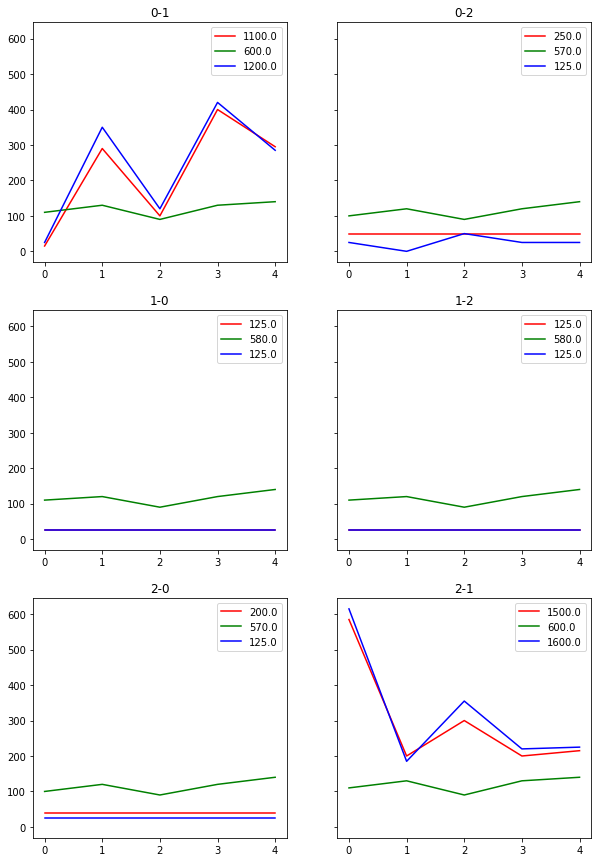

In [198]:
plot_xyw(len(ivs_arrival), a_xlines)

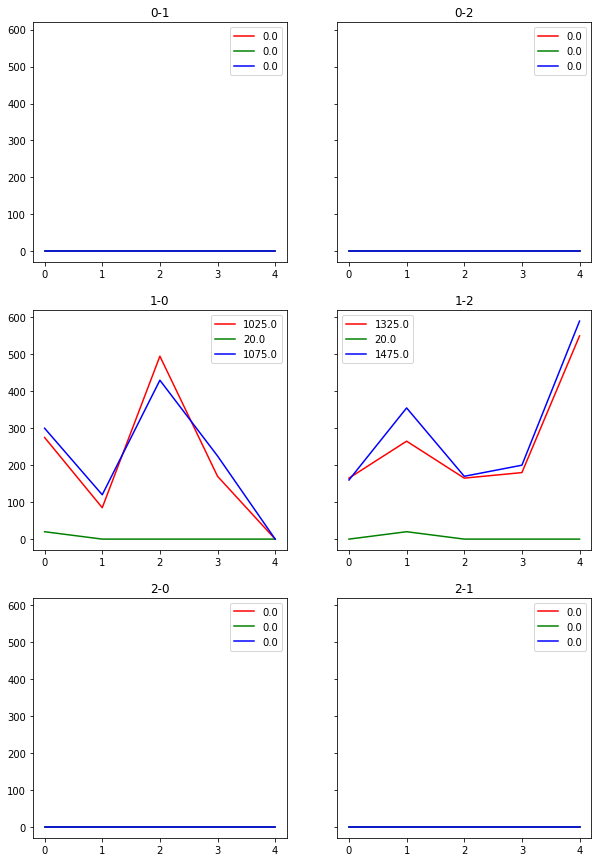

In [199]:
plot_xyw(len(ivs_arrival), a_ylines)

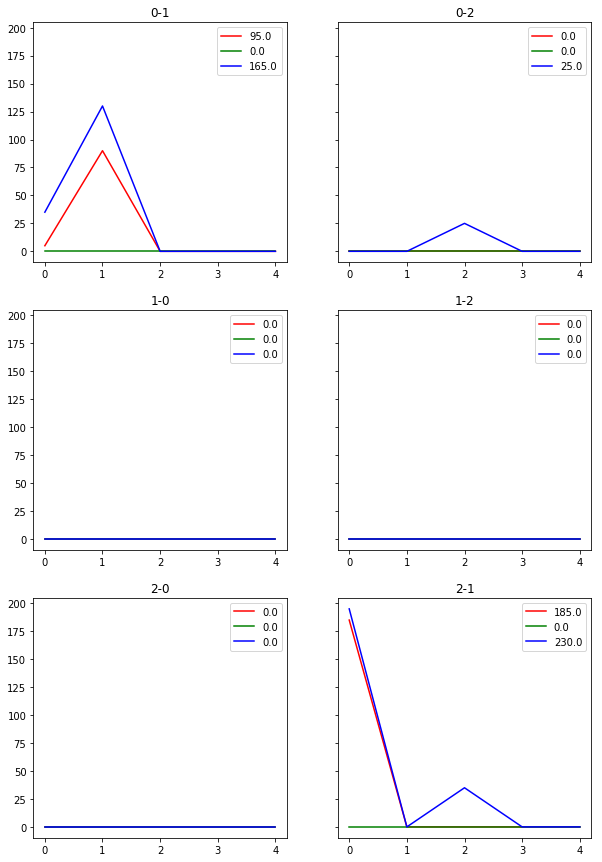

In [200]:
plot_xyw(len(ivs_arrival), a_wlines)

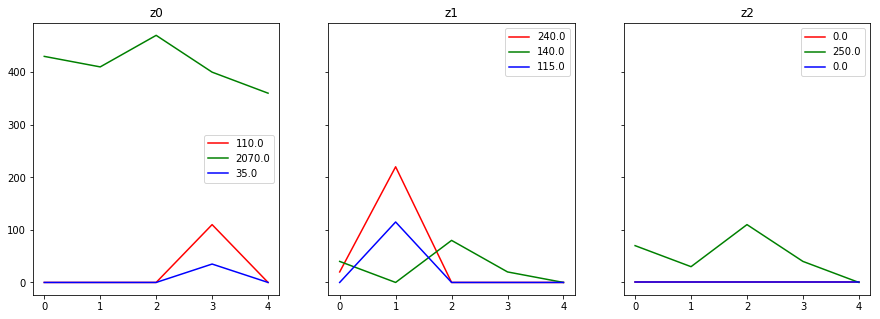

In [201]:
plot_z(len(ivs_arrival), a_zlines)

In [213]:
# change fleet, control arrivals
f_xlines, f_ylines, f_zlines, f_wlines = res(ivs_fleet)

========== new model ==========
model f1200
fleet=1200
arrivals:
[[[0, 100, 50], [25, 0, 25], [40, 400, 0]],
 [[0, 200, 50], [25, 0, 25], [40, 200, 0]],
 [[0, 100, 50], [25, 0, 25], [40, 300, 0]],
 [[0, 400, 50], [25, 0, 25], [40, 200, 0]],
 [[0, 300, 50], [25, 0, 25], [40, 400, 0]]]

Optimize a model with 50 rows, 105 columns and 315 nonzeros
Variable types: 0 continuous, 105 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+03]
Presolve time: 0.00s
Presolved: 50 rows, 105 columns, 315 nonzeros
Variable types: 0 continuous, 105 integer (0 binary)

Root relaxation: objective 1.792500e+04, 48 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    17925.000000 17925.0000  0.00%     -    0s

Explored 0 nodes (48 si

xlines: [[15.0, 290.0, 100.0, 400.0, 295.0, 100.0, 200.0, 100.0, 400.0, 300.0, 100.0, 200.0, 100.0, 400.0, 300.0, 100.0, 200.0, 100.0, 400.0, 300.0], [50.0, 50.0, 50.0, 50.0, 50.0, 60.0, 50.0, 50.0, 50.0, 40.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0], [25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0], [25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0], [40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0], [585.0, 200.0, 300.0, 200.0, 215.0, 480.0, 200.0, 300.0, 200.0, 320.0, 400.0, 200.0, 300.0, 200.0, 400.0, 400.0, 200.0, 300.0, 200.0, 400.0]]
ylines: [[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0

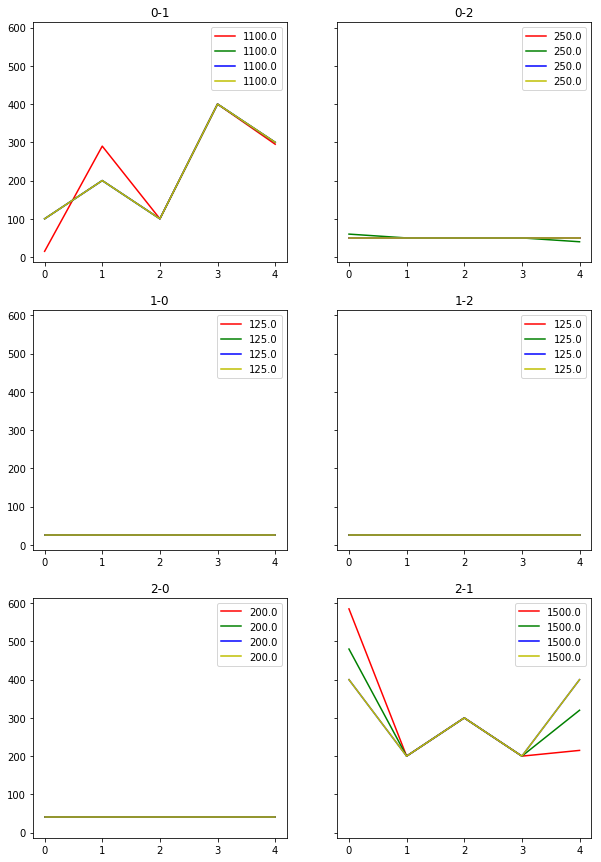

In [214]:
plot_xyw(len(ivs_fleet), f_xlines)

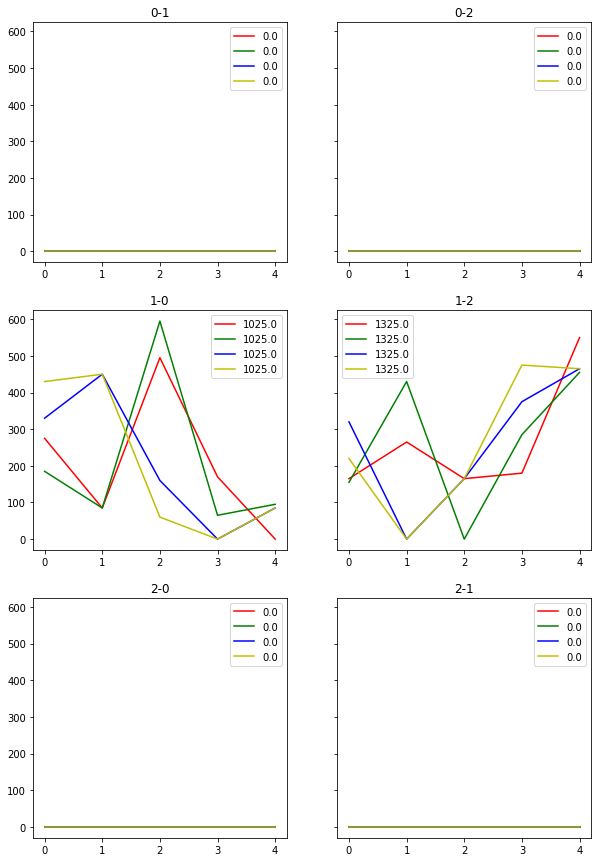

In [215]:
plot_xyw(len(ivs_fleet), f_ylines)

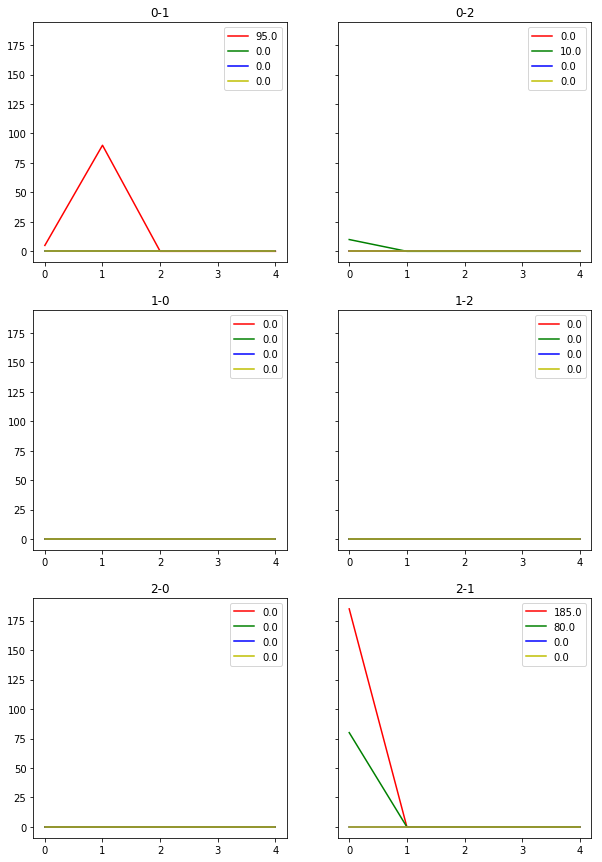

In [216]:
plot_xyw(len(ivs_fleet), f_wlines)

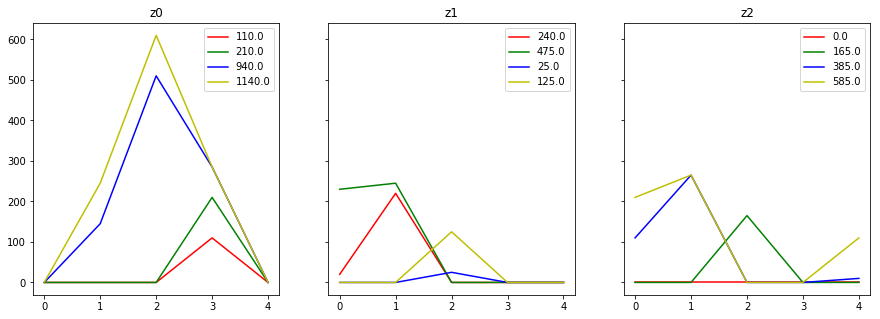

In [217]:
plot_z(len(ivs_fleet), f_zlines)

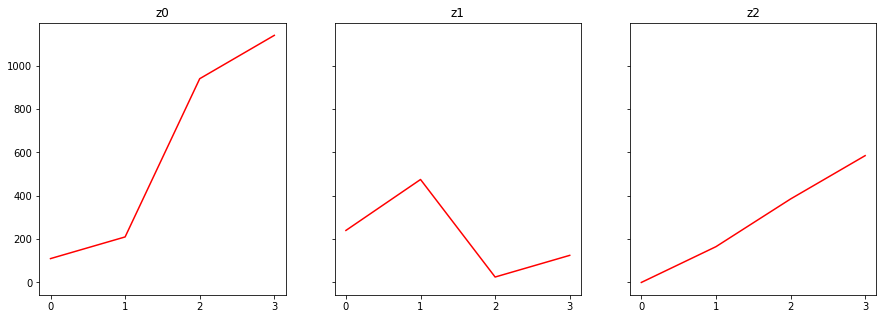

In [218]:
# fleet
def plot_fleet_zsum():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    for i in range(3):
        zsum = []
        for k in range(len(ivs_fleet)):
            zsum.append(sum(f_zlines[i][k*5:(k+1)*5]))
        l = axes[i].plot(zsum, axes=axes[i], color='r')
        axes[i].set_title('z{}'.format(i))
        axes[i].set_xticks([i for i in range(len(ivs_fleet))])
plot_fleet_zsum()

### Notes 12.1
- x-axis = days, lines for different fleet/arrival for certain (i, j)
- change fleet:
    - sum(x) does not change, but more balanced between days; consider day by day, the days with more x remedy the days with less x
    - sum(y) does not change
    - w(is cumulative) generally decreases (compare within certain day) as fleet in creases; if there's more w it needs more x (also more cost because more left not transported), but if x more smooth, means there's less extreme w, incurs less cost
    - sum(z) generally increases, but no patterns along days (but mostly due to increase of fleet)

- change cargo arrival:
    - x becomes more balanced between days as well as locations
    - y decreases a great deal
    - w becomes 0 which is ideal
    - z increases because y decreases